In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [3]:
# Import libraries
from radiomics import featureextractor
from scipy.stats import wilcoxon
from time import time
import matplotlib.pyplot as plt
import numpy.matlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.preprocessing import StandardScaler
import SimpleITK as sitk
import six
import trimesh
import numpy as np
from numpy import linalg
import os
import pywt
import pickle
import sys
from scipy.stats import linregress
import pandas as pd
import nrrd
#from util import plot_correlation_heatmap
import logging

#%matplotlib widget

In [4]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (25,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [5]:
uncorrected_dir_s1 = '/media/mts_dbs/caff/t1_t2/HV1_R2s/'
corrected_dir_s1 = '/media/mts_dbs/caff/t1_t2/HV1_R2sc/'
uncorrected_dir_s2 = '/media/mts_dbs/caff/t1_t2/HV2_R2s/'
corrected_dir_s2 = '/media/mts_dbs/caff/t1_t2/HV2_R2sc/'
roi_dir_s1 = '/media/mts_dbs/caff/t1_t2/HV1_roi/'
roi_dir_s2 = '/media/mts_dbs/caff/t1_t2/HV2_roi/'
s1_niis = sorted(os.listdir(roi_dir_s1))
s2_niis = sorted(os.listdir(roi_dir_s2))
r2s_s1_dir = sorted(os.listdir(uncorrected_dir_s1))
r2s_s2_dir = sorted(os.listdir(uncorrected_dir_s2))
r2sc_s1_dir = sorted(os.listdir(corrected_dir_s1))
r2sc_s2_dir = sorted(os.listdir(corrected_dir_s2))

In [6]:
plt.close('all')
visualize = 0
# Load data
r2ss_s1 = []
r2scs_s1 = []
r2ss_s2 = []
r2scs_s2 = []
segs_s1 = []
segs_s2 = []
voxel_sizes_s1 = []
voxel_sizes_s2 = []
trackers = []
dir = '/media/mts_dbs/caff/t1_t2'
files = os.listdir(dir)
n_cases = len(s1_niis)
for j in np.arange(n_cases):
        seg_s1 = nib.load(roi_dir_s1+s1_niis[int(j)])
        r2s_s1 = nib.load(uncorrected_dir_s1+r2s_s1_dir[int(j)])
        r2sc_s1 = nib.load(corrected_dir_s1+r2sc_s1_dir[int(j)])
        r2ss_s1.append(np.asarray(r2s_s1.get_fdata()))
        r2scs_s1.append(np.asarray(r2sc_s1.get_fdata()))
        segs_s1.append(np.asarray(seg_s1.get_fdata()))
        voxel_size_s1 = seg_s1.header['pixdim'][1:4]
        voxel_sizes_s1.append(voxel_size_s1)

        seg_s2 = nib.load(roi_dir_s2+s2_niis[int(j)])
        r2s_s2 = nib.load(uncorrected_dir_s2+r2s_s2_dir[int(j)])
        r2sc_s2 = nib.load(corrected_dir_s2+r2sc_s2_dir[int(j)])
        r2ss_s2.append(np.asarray(r2s_s2.get_fdata()))
        r2scs_s2.append(np.asarray(r2sc_s2.get_fdata()))
        segs_s2.append(np.asarray(seg_s2.get_fdata()))
        voxel_size_s2 = seg_s2.header['pixdim'][1:4]
        voxel_sizes_s2.append(voxel_size_s2)

        if visualize == 1:
                multi_slice_viewer(np.hstack((r2ss_s1[j].T+(segs_s1[j].T),r2scs_s1[j].T+(segs_s1[j].T))))
                multi_slice_viewer(np.hstack((r2ss_s2[j].T+(segs_s2[j].T),r2scs_s2[j].T+(segs_s2[j].T))))




In [7]:
# Only extract ROI if it is present in all cases
seg_labels_all = segs_s1[0]
for i in range(n_cases-1):
    seg_s1_labels = np.intersect1d(segs_s1[i],segs_s1[i+1])
    seg_s2_labels = np.intersect1d(segs_s2[i],segs_s2[i+1])
    seg_labels = np.intersect1d(seg_s1_labels,seg_s2_labels)
    seg_labels_all = np.intersect1d(seg_labels_all,seg_labels)

seg_labels_all = seg_labels_all[seg_labels_all < 30]

In [8]:
# Generate feature structure Phi from all ROIs and all cases
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()
extractor.enableFeatureClassByName('shape2D',enabled = False)

In [10]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

Phi_R2s_s1 = []
Phi_R2sc_s1 = []
Phi_R2s_s2 = []
Phi_R2sc_s2 = []
seg_labels = []
reextract = 0
x_r2s_s1 = []
x_r2sc_s1 = []
x_r2s_s2 = []
x_r2sc_s2 = []
keylib = []
roilib = []
loop_count = 0
roi_names = []
roi_txt = pd.read_csv("/data/Ali/atlas/freesurfer/FsTutorial_AnatomicalROI_FreeSurferColorLUT.csv")
n_rois = seg_labels_all[seg_labels_all>0].__len__()
if reextract == 1:
    for i in range(n_cases):
        seg_sitk_s1 = sitk.GetImageFromArray(segs_s1[i])
        seg_sitk_s1.SetSpacing(voxel_sizes_s1[i].tolist())
        r2s_sitk_s1 = sitk.GetImageFromArray(r2ss_s1[i])
        r2s_sitk_s1.SetSpacing(voxel_sizes_s1[i].tolist())
        r2sc_sitk_s1 = sitk.GetImageFromArray(r2scs_s1[i])
        r2sc_sitk_s1.SetSpacing(voxel_sizes_s1[i].tolist())

        seg_sitk_s2 = sitk.GetImageFromArray(segs_s2[i])
        seg_sitk_s2.SetSpacing(voxel_sizes_s2[i].tolist())
        r2s_sitk_s2 = sitk.GetImageFromArray(r2ss_s2[i])
        r2s_sitk_s2.SetSpacing(voxel_sizes_s2[i].tolist())
        r2sc_sitk_s2 = sitk.GetImageFromArray(r2scs_s2[i])
        r2sc_sitk_s2.SetSpacing(voxel_sizes_s2[i].tolist())
        for j in seg_labels_all:
            if j > 0:
                    print('Extracting features for subject '+str(i)+' at ROI '+str(int(j)))
                    featureVector_r2s_s1 = extractor.execute(r2s_sitk_s1,seg_sitk_s1,label=int(j))
                    featureVector_r2s_s2 = extractor.execute(r2s_sitk_s2,seg_sitk_s2,label=int(j))
                    Phi_R2s_s1.append(featureVector_r2s_s1)
                    Phi_R2s_s2.append(featureVector_r2s_s2)

                    featureVector_r2sc_s1 = extractor.execute(r2sc_sitk_s1,seg_sitk_s1,label=int(j))
                    featureVector_r2sc_s2 = extractor.execute(r2sc_sitk_s2,seg_sitk_s2,label=int(j))
                    Phi_R2sc_s1.append(featureVector_r2sc_s1)
                    Phi_R2sc_s2.append(featureVector_r2sc_s2)

                    for key, value in six.iteritems(featureVector_r2s_s1):
                        if 'diagnostic' in key:
                            next
                        else:
                            x_r2s_s1.append(featureVector_r2s_s1[key])
                            x_r2sc_s1.append(featureVector_r2sc_s1[key])
                            x_r2s_s2.append(featureVector_r2s_s2[key])
                            x_r2sc_s2.append(featureVector_r2sc_s2[key])
                            keylib.append(key)
                            roilib.append(seg_labels_all[np.mod(loop_count,n_rois)])
                            loop_count = loop_count+1

                    
    
    X0_r2s_s1 = np.array(x_r2s_s1)
    X0_r2sc_s1 = np.array(x_r2sc_s1)
    X0_r2s_s2 = np.array(x_r2s_s2)
    X0_r2sc_s2 = np.array(x_r2sc_s2)
    np.save('X0_R2s_s1.npy',X0_r2s_s1)
    np.save('X0_R2sc_s1.npy',X0_r2sc_s1)
    np.save('X0_R2s_s2.npy',X0_r2s_s2)
    np.save('X0_R2sc_s2.npy',X0_r2sc_s2)
    K = np.asarray(keylib)
    np.save('K_r2s.npy',K)

    print('Saving R2s at timepoint 1')
    with open('Phi_R2s_s1', 'wb') as fp:  
        pickle.dump(Phi_R2s_s1, fp)
    
    print('Saving R2sc at timepoint 1')
    with open('Phi_R2sc_s1', 'wb') as fp:  
        pickle.dump(Phi_R2sc_s1, fp)

    print('Saving R2s at timepoint 2')
    with open('Phi_R2s_s2', 'wb') as fp:  
        pickle.dump(Phi_R2s_s2, fp)
    
    print('Saving R2sc at timepoint 2')
    with open('Phi_R2sc_s2', 'wb') as fp:  
        pickle.dump(Phi_R2sc_s2, fp)

else:
    X0_r2s_s1 = np.load('./npy/old/X0_R2s_s1.npy')
    X0_r2sc_s1 = np.load('./npy/old/X0_R2sc_s1.npy')
    X0_r2s_s2 = np.load('./npy/old/X0_R2s_s2.npy')
    X0_r2sc_s2 = np.load('./npy/old/X0_R2sc_s2.npy')
    K = np.load('./npy/old/K_r2s.npy')
    

In [11]:
with open('./phi/qRadAR/Phi_R2s_s1', 'rb') as fp:  
    Phi_R2s_s1 = pickle.load(fp)
    
with open('./phi/qRadAR/Phi_R2sc_s1', 'rb') as fp:  
    Phi_R2sc_s1 = pickle.load(fp)

with open('./phi/qRadAR/Phi_R2s_s2', 'rb') as fp:  
    Phi_R2s_s2 = pickle.load(fp)
    
with open('./phi/qRadAR/Phi_R2sc_s2', 'rb') as fp:  
    Phi_R2sc_s2 = pickle.load(fp)

In [12]:
Phi_R2s_s2.__len__()/n_cases

17.0

In [13]:
Phi_R2s_s1.__len__()

136

In [14]:
n_cases

8

In [15]:
n_roisc = int(Phi_R2s_s1.__len__()/n_cases)

In [16]:
L = int((X0_r2s_s1.shape[0])/n_cases)
n_features = int(L/n_roisc)

In [17]:
X0_r2s_s1  = X0_r2s_s1.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_r2s_s2 = X0_r2s_s2.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_r2sc_s1 = X0_r2sc_s1.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_r2sc_s2 = X0_r2sc_s2.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
K_rs = K.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))

In [18]:
Mc = np.zeros((X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]))
Mic = np.zeros((X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]))
Miv = np.zeros((X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]))
Mcv = np.zeros((X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]))
Mcm = np.zeros((X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]))
Kc = np.empty((X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]),dtype=object)

In [19]:
def ccc(X01,X02):
    sigma1 = np.std(X01,axis = 0)
    sigma2 = np.std(X02,axis = 0)
    mu1 = np.mean(X01,axis = 0)
    mu2 = np.mean(X02,axis = 0)
    cov = np.mean((X01-mu1)*(X02-mu2),axis = 0)
    rho = cov/(sigma1*sigma2)
    rhoc = (2*rho*sigma1*sigma2)/(sigma1**2+sigma2**2+(mu1-mu2)**2)
    return rhoc

In [20]:
def icc(df):
    m = df.shape[0]
    k = df.shape[1]
    mu = np.nanmean(df)
    mu_j = df.mean(axis = 0)
    mu_i = df.mean(axis = 1)
    sT = (k/(m-1))*np.sum((mu-mu_i)**2)
    T = df
    sE = np.sum(np.sum((T-np.matlib.repmat(mu_i,k,1).T-np.matlib.repmat(mu_j,m,1)+mu)**2))/((m-1)*(k-1))
    rho = (sT-sE)/(sT+(k-1)*sE)
    return rho

In [21]:
def cv(X01,X02):
    sigma = np.std((X01,X02),axis = 0)
    mu = np.mean((X01,X02),axis = 0)
    cv = np.mean(sigma/mu)
    return cv

In [22]:
for i in np.arange(X0_r2s_s1.shape[1]):
    for j in np.arange(X0_r2s_s1.shape[2]):
        Mcv[i,j] = ccc(X0_r2s_s1[:,i,j],X0_r2s_s2[:,i,j])
        Mcm[i,j] = ccc(X0_r2sc_s1[:,i,j],X0_r2sc_s2[:,i,j])
        Kc[i,j] = K_rs[1,i,j]

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [23]:
np.median(Mcv[~np.isnan(Mcv+Mcm).any(axis = 1),:])

0.20146143714378098

In [24]:
np.median(Mcm[~np.isnan(Mcv+Mcm).any(axis = 1),:])

0.20074653619195584

In [25]:
res = wilcoxon(Mcv.ravel(),Mcm.ravel())
res.statistic, res.pvalue

(106805648.0, 1.346880707704229e-288)

In [26]:
for i in np.arange(X0_r2sc_s1.shape[1]):
    for j in np.arange(X0_r2sc_s1.shape[2]):
        dataset = np.vstack((X0_r2s_s1[:,i,j],X0_r2s_s2[:,i,j]))
        datasetc = np.vstack((X0_r2sc_s1[:,i,j],X0_r2sc_s2[:,i,j]))
        Mic[i,j] = icc(datasetc.T)
        Miv[i,j] = icc(dataset.T)

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [27]:
np.median(Mic[~np.isnan(Mic+Miv).any(axis = 1),:])

0.31069510369646136

In [28]:
np.median(Miv[~np.isnan(Mic+Miv).any(axis = 1),:])

0.3080025428688904

In [29]:
res = wilcoxon(Mic.ravel(),Miv.ravel())
res.statistic, res.pvalue

(110665310.0, 5.136905313966956e-205)

In [32]:
rho = Mc*Mic
Mc = Mc[~np.isnan(rho).any(axis = 1),:]
Mic = Mic[~np.isnan(rho).any(axis = 1),:]
#Kc = Kc[~np.isnan(rho).any(axis = 1),:]
rhoc = Mc*Mic

In [33]:
for i in np.arange(X0_r2s_s1.shape[1]):
    for j in np.arange(X0_r2s_s1.shape[2]):
        Mcv[i,j] = cv(X0_r2s_s1[:,i,j],X0_r2s_s2[:,i,j])
        Mcm[i,j] = cv(X0_r2sc_s1[:,i,j],X0_r2sc_s2[:,i,j])

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [34]:
Mcvc = Mcv[~np.isnan(Mcv+Mcm).any(axis = 1),:]
Mcmc = Mcm[~np.isnan(Mcv+Mcm).any(axis = 1),:]
Kcs = Kc[~np.isnan(Mcv+Mcm).any(axis = 1),:]

In [35]:
np.median(Mcvc)

0.07944430056502691

In [36]:
np.median(Mcmc)

0.07939245099528519

In [37]:
idx = [~np.isnan(np.log(abs(X0_r2s_s1.ravel()+1))+np.log(abs(X0_r2s_s2.ravel()+1))+np.log(abs(X0_r2sc_s1.ravel()+1))+np.log(abs(X0_r2sc_s2.ravel()+1)))]

In [65]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    diff_in = np.logical_and(diff < md + 1.96*sd,diff > md - 1.96*sd)
    print(diff_in)
    print('Limits of agreement are:',str(md-1.96*sd),str(md+1.96*sd))
    print('Fraction of features within limits of agreement: ',str(sum(diff_in)/len(diff)))
    return diff

In [80]:
X0_r2sc_s1.shape

(8, 1595, 17)

[ True  True  True ...  True  True  True]
Limits of agreement are: -0.5806568580897039 0.5806568580897039
Fraction of features within limits of agreement:  0.9942328969205237


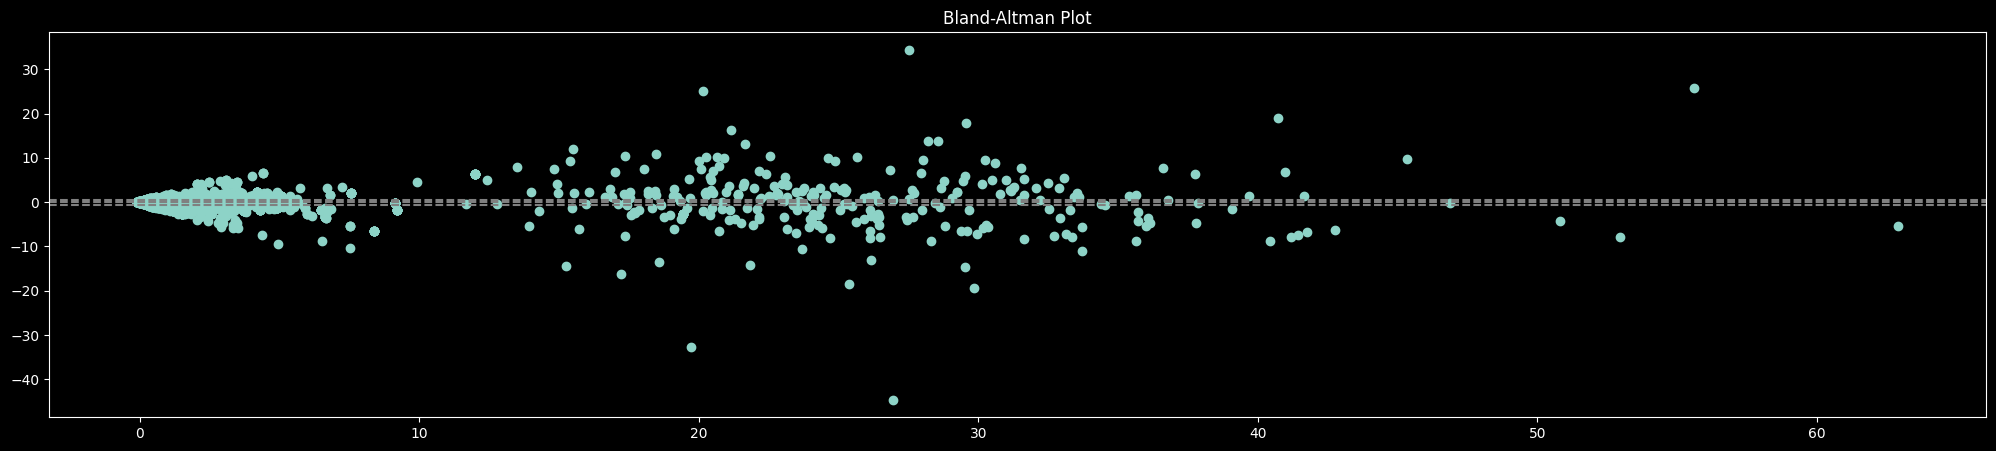

In [84]:
scaler = StandardScaler()
# Transform feature matrix and UPDRS
X_r2snc_r1 = scaler.fit_transform(X0_r2sc_s1.reshape(X0_r2sc_s1.shape[0]*X0_r2sc_s1.shape[1],X0_r2sc_s1.shape[2]))
X_r2snc_r2 = scaler.fit_transform(X0_r2sc_s2.reshape(X0_r2sc_s2.shape[0]*X0_r2sc_s2.shape[1],X0_r2sc_s2.shape[2]))
#diff = bland_altman_plot(np.log(abs(X0_r2s_s1.ravel()[idx]+1)), np.log(abs(X0_r2s_s2.ravel()[idx]+1)))
diffc = bland_altman_plot(X_r2snc_r1.ravel(),X_r2snc_r2.ravel())
plt.title('Bland-Altman Plot')
plt.show()

[ True  True  True ...  True  True  True]
Limits of agreement are: -0.73273467954259 0.7136790103483279
Fraction of features within limits of agreement:  0.9953254656094412


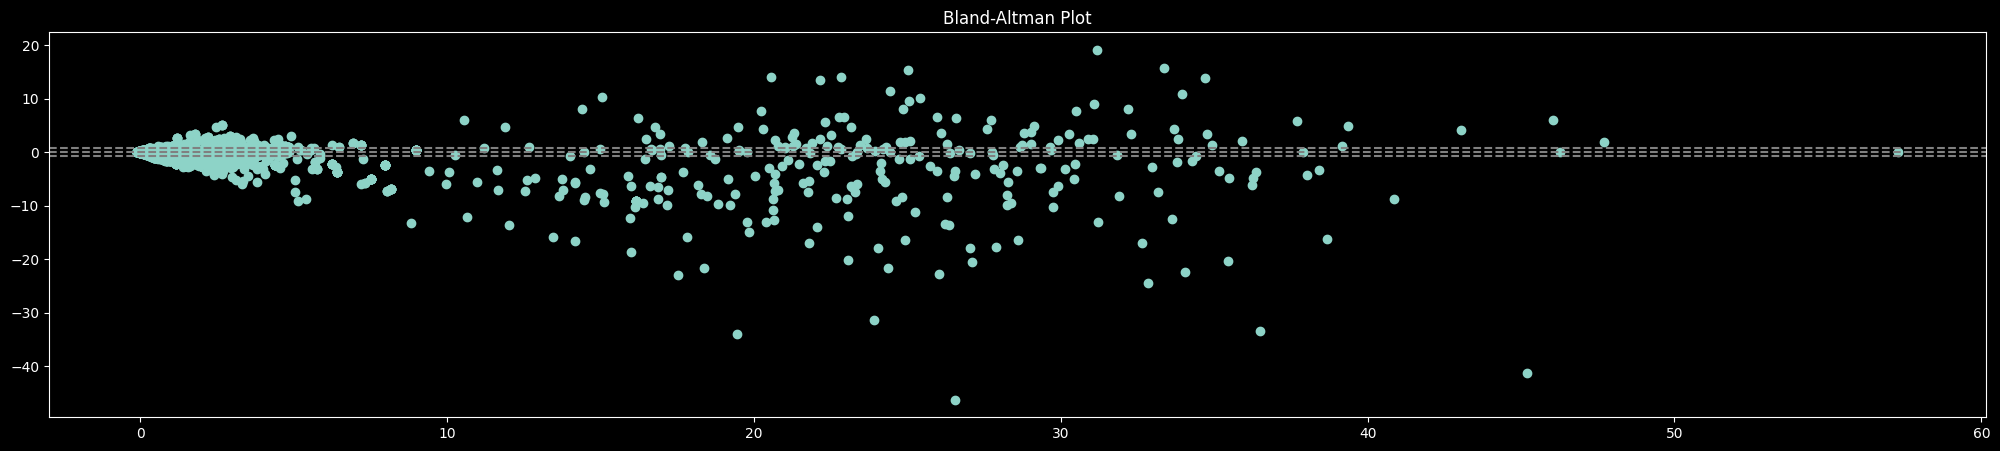

In [85]:

# Transform feature matrix and UPDRS
X_r2sn_r1 = scaler.transform(X0_r2s_s1.reshape(X0_r2s_s1.shape[0]*X0_r2s_s1.shape[1],X0_r2s_s1.shape[2]))
X_r2sn_r2 = scaler.transform(X0_r2s_s2.reshape(X0_r2s_s2.shape[0]*X0_r2s_s2.shape[1],X0_r2s_s2.shape[2]))
#diff = bland_altman_plot(np.log(abs(X0_r2s_s1.ravel()[idx]+1)), np.log(abs(X0_r2s_s2.ravel()[idx]+1)))
diff = bland_altman_plot(X_r2sn_r1.ravel(),X_r2sn_r2.ravel())
plt.title('Bland-Altman Plot')
plt.show()

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


[ True  True  True ...  True  True  True]
Limits of agreement are: -1.2999594959536587 1.2287691076196123
Fraction of features within limits of agreement:  0.9651807117831459


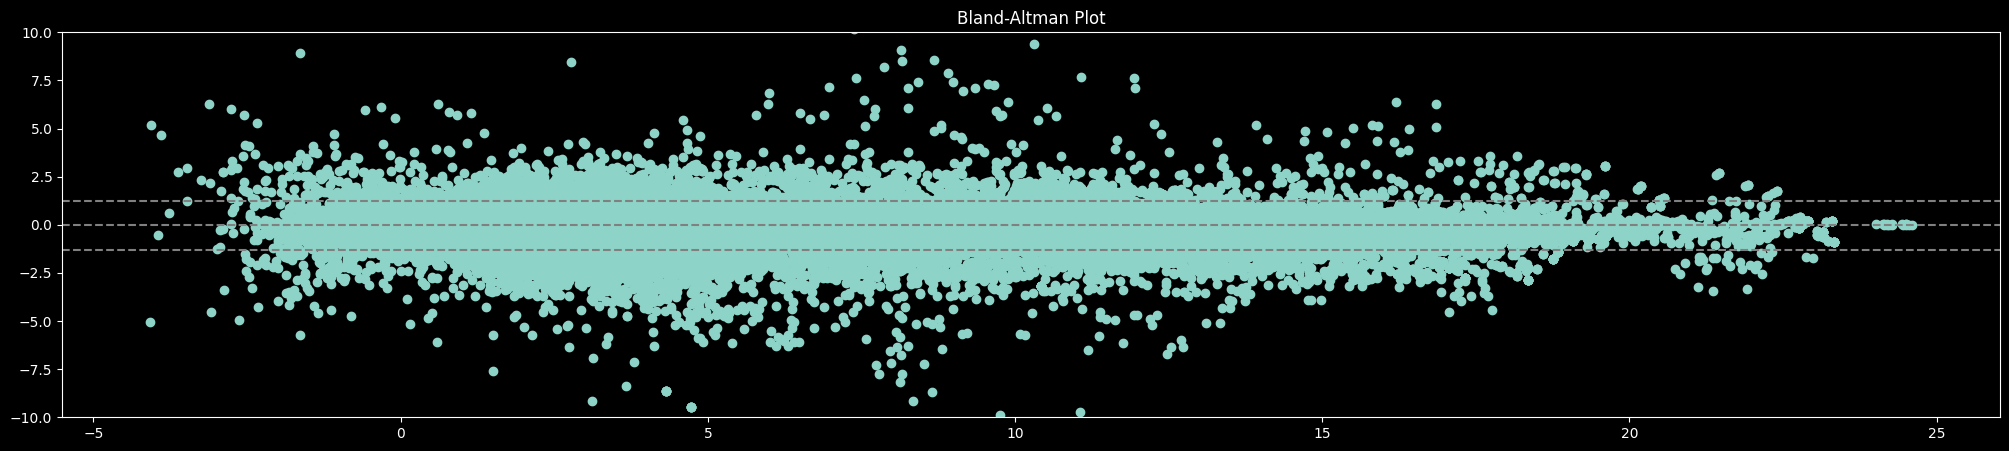

In [40]:
diffc = bland_altman_plot(np.log(abs(X0_r2sc_s1.ravel()[idx]+1)), np.log(abs(X0_r2sc_s2.ravel()[idx]+1)))
plt.title('Bland-Altman Plot')
plt.show()

In [53]:
np.median(abs(diff))

0.027700456523210903

In [54]:
np.median(abs(diffc))

0.027718481791035643

In [57]:
res = wilcoxon(diff.ravel(),diffc.ravel())
res.statistic, res.pvalue

(5673279153.5, 5.7208157483008105e-05)

In [42]:
idx_max_vsharp = abs(Mcvc).sum(axis=1).argsort()[::-1]
idx_min_vsharp = abs(Mcvc).sum(axis=1).argsort()[::1]

idx_max_msmv = abs(Mcmc).sum(axis=1).argsort()[::-1]
idx_min_msmv = abs(Mcmc).sum(axis=1).argsort()[::1]

In [ ]:
n = 100
Kcs_max= np.intersect1d(idx_max_vsharp[1:n],idx_max_msmv[1:n])
Kcs_min = np.intersect1d(idx_min_vsharp[1:n],idx_min_msmv[1:n])

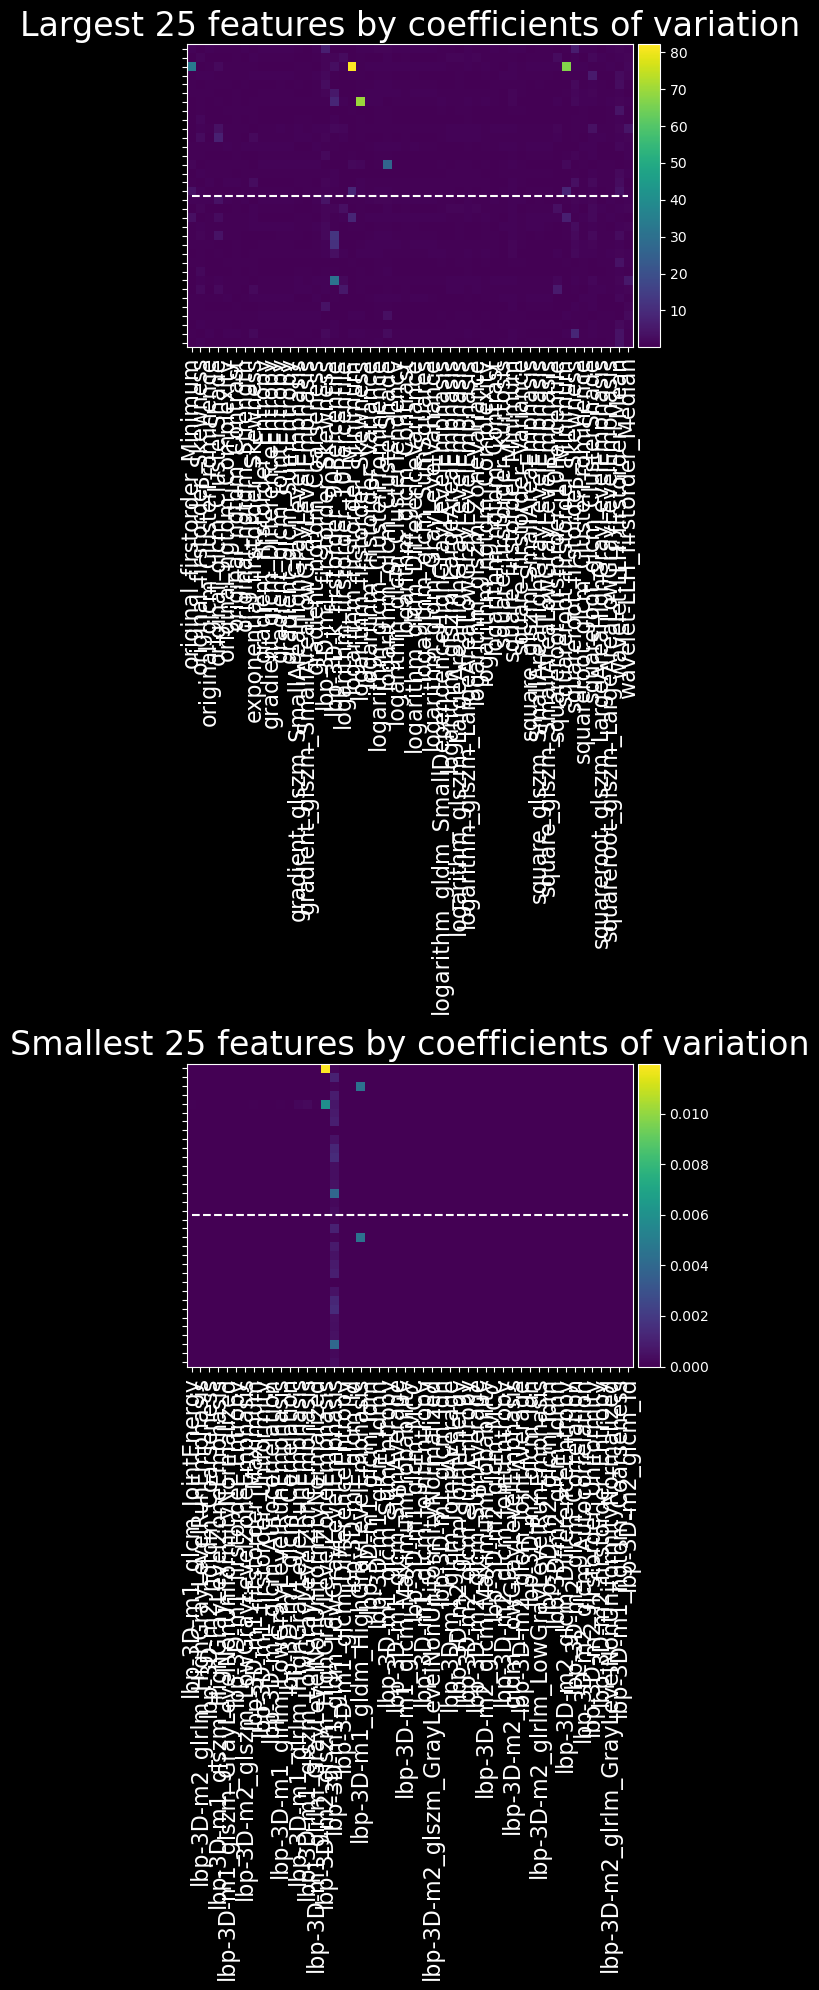

In [ ]:
plt.close('all') 

fig, ax = plt.subplots(2,1,figsize = (20,20))

im = ax[0].imshow(np.vstack((abs(Mcvc)[Kcs_max[:n//2],:].T,abs(Mcmc)[Kcs_max[:n//2],:].T)),interpolation='nearest')
ax[0].hlines(n_rois-0.5,0,n//2-1, linestyle='dashed',color='white')
ax[0].set_title('Largest 25 features by coefficients of variation',fontsize=24)
ax[0].set_xticks(np.arange(Mcvc[idx_max_vsharp[:n//2]].shape[0]))
ax[0].set_yticks(np.arange(2*Mcvc[idx_max_vsharp[:n//2]].shape[1]))
ax[0].set_xticklabels(Kcs[Kcs_max[:n//2],1], rotation='vertical', fontsize=16)
ax[0].set_yticklabels(np.matlib.repmat(roi_names[:n_rois],2,1).ravel(),rotation='horizontal',fontsize=16)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(np.vstack((abs(Mcvc)[Kcs_min[:n//2],:].T,abs(Mcmc)[Kcs_min[:n//2],:].T)),interpolation='nearest')
ax[1].hlines(n_rois-0.5,0,n//2-1, linestyle='dashed',color='white')
ax[1].set_title('Smallest 25 features by coefficients of variation',fontsize=24)
ax[1].set_xticks(np.arange(Mcvc[idx_min_vsharp[:n//2]].shape[0]))
ax[1].set_yticks(np.arange(2*Mcvc[idx_min_vsharp[:n//2]].shape[1]))
ax[1].set_xticklabels(Kcs[idx_min_vsharp[:n//2],1], rotation='vertical', fontsize=16)
ax[1].set_yticklabels(np.matlib.repmat(roi_names[:n_rois],2,1).ravel(),rotation='horizontal',fontsize=16)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
Kcs = np.empty((Mc.shape[0],Mc.shape[1]),dtype=object)
im_type = np.empty((Mc.shape[0],Mc.shape[1]),dtype=object)
feat_class = np.empty((Mc.shape[0],Mc.shape[1]),dtype=object)

rhoc_exp = []
lbp_count = 0
log_count = 0
orig_count = 0
square_count = 0
squareroot_count = 0
wavelet_count = 0
for i in np.arange(Mc.shape[0]):
    for j in np.arange(Mc.shape[1]):
        feat_class[i,j] = Kc[i,j].rsplit('_',2)[1]
        im_type[i,j] = Kc[i,j].rsplit('_',2)[0]
        Kcs[i,j] = Kc[i,j].rsplit('_',1)[1]
        if im_type[i,j] == 'exponential':
            rhoc_exp.append(rhoc[i,j])
        if im_type[i,j] == 'lbp-3D-k':
            lbp_count = lbp_count+1
        if im_type[i,j] == 'logarithm':
            log_count = log_count+1
        if im_type[i,j] == 'original':
            orig_count = orig_count+1
        if im_type[i,j] == 'square':
            square_count = square_count+1
        if im_type[i,j] == 'squareroot':
            squareroot_count = squareroot_count+1
        if 'wavelet' in im_type[i,j]:
            wavelet_count = wavelet_count+1


In [ ]:
def filter_keys(d, keys):
    return {k: v for k, v in d.items() if keys not in k}

In [ ]:
def find_keys(d, keys):
    return {k: v for k, v in d.items() if keys in k}